We are going to implement a code for Linear Quadratic Control problem 

Loss function = $\dfrac1M\sum_{t=0}^{N-1}((aX_t^2+bX_t+Au_t^2+Bu_t)\delta_t+\alpha X_T^2+\beta X_T)$

where $\delta_t=\frac{N}{T}$

State Process $X_{t+1}=X_t+(cX_t+du_t)\delta_t+\sigma\delta_t\epsilon_t$

The HJB equation is given by

$0=\partial_t V(t,x)+\frac{\sigma^2}{2}\partial_x^2V(t,x) +cx\partial_xV(t,x)+ax^2+bx+\inf_u\Big[Au^2+\Big(B+d\partial_xV(t,x)\Big)u\Big]$

$V(T,x)=\alpha x^2+\beta x$.

The optimal solution solution obtained as
$u^*=-\frac{B+d\partial_xV(t,x)}{2A}$
depends on the value function $V(t,x)$, which is the solution of the following PDE
$0=\partial_t V(t,x)+\frac{\sigma^2}{2}\partial_x^2V(t,x) +cx\partial_xV(t,x)+ax^2+bx-\frac{\big(B+d\partial_xV(t,x)\big)^2}{4A}$

$V(T,x)=\alpha x^2+\beta x$.

We assume that the value function is quadratic in $x$,

$V(t,x)=f(t)x^2+h(t)x+k(t)$. 

By substituting $V$ in the HJB PDE we get the following system of Riccati ODE.

$0=f'+a+2cf-\frac{d^2}{A}f^2;  f(T)=\alpha$

$0=h'+b-\frac{(B+dh)d}{A}f;  h(T)=\beta$

$0=k'+\sigma^2 f-\frac{1}{4A}(B+dh)^2;  k(T)=0$

By solving this system of first order ODE we can get $f,h,t$ in closed form and we obtain the optimal solution as

$u^*=-\frac{B+d(2xf(t)+h(t))}{2A}$

In [16]:
import numpy as np
import time
from scipy import misc
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import pandas as pd
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp

import json

In [17]:
M=100
ite=100
T=1
delta = torch.tensor(T/ite)
a=0.1
b=0.1
c=0.1
d=0.1
A=0.1
B=0.1
sigma=0.01
alpa=0.1
beta=0.1
neuron_model_psi=50
dim_n=2
print(delta)

tensor(0.0100)


In [18]:
# model= torch.nn.Sequential(
#     torch.nn.Linear(dim_n, neuron_model_psi),
#     torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
#     torch.nn.ReLU(),
# #     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
# #     torch.nn.ReLU(),
# #     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
# #     torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi,1)
# )

In [19]:
model= torch.load('model_N100_LQC_uniform_0_1_alpa_0.1.pth')


In [5]:
t=torch.zeros([M,1])
up_lim=1
#z=np.zeros([M,ite+1])+np.random.rand(M,1)
# z=torch.FloatTensor(M,ite+1).uniform_(0,0.01)
z=0.01*torch.normal(0, 1, size=(M, ite+1))
# x_train=torch.FloatTensor(M,1).uniform_(0,up_lim)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
x_train=torch.normal(0, 1, size=(M, 1))
data=torch.cat((t,x_train),dim=1)
# print(data.dtype)
# print(z.dtype)
# print(z[:,2].shape)
#print(x)

In [20]:
def update(x3,psi,z,i):
    t=(x3[:,0]+(T/ite))
    #print(x3[:,1].shape,z[:,i].shape,psi.shape)
    x=x3[:,1]+(c*x3[:,1]+d*psi)*delta+sigma*torch.sqrt(delta)*z[:,i]
    up=torch.cat((t.unsqueeze(1),x.unsqueeze(1)),dim=1)
#     print('up shape=', up.shape)
    return up

def loss_func(x2,psi):
    loss=a*torch.pow(x2[:,1],2)+b*x2[:,1]+A*torch.pow(psi,2)+B*psi
    return loss

def loss_func_ter(x4):
    loss=alpa*torch.pow(x4[:,1],2)+beta*x4[:,1]
    return loss

def unit(x1,model,i):
    psi=model(x1).squeeze(1)
    los=loss_func(x1,psi)
    upd=update(x1,psi,z,i)
    #print('unit print=',psi.shape,los.shape,upd.shape)
    return psi,los,upd

def loss_func_total(u,model,epoch):
    loss=torch.zeros(M,ite)
    psi=torch.zeros(M,ite)
    state_var=[]
    if (epoch==max_epoch-1):
        state_var.append(u.detach().numpy())   
    for i in range(ite+1):
        if(i<ite):
            psi_run,loss_run,u_run=unit(u,model,i)
            #print('los func=',psi_run.shape,loss_run.shape)
            loss[:,i]=loss_run
            #print(loss)
            psi[:,i]=psi_run
            #print(psi)
            u=u_run
            if (epoch==max_epoch-1):
                state_var.append(u.detach().numpy())             
            #print(u)
        else:
            loss_ter=loss_func_ter(u)
          #print('ter',loss_ter.shape)
        #print(torch.sum(loss,dim=1))
    loss=torch.sum(loss,dim=1)*delta+loss_ter
    #print(loss.shape)
    return torch.mean(loss),state_var


In [21]:
# start=time.time()
# lr1 = 8e-3
# max_epoch = 3000
# cost_ar=[]
# optimizer = optim.Adam(model.parameters(), lr1)

# #print(psi.shape)
# for epoch in range(max_epoch):
#   optimizer.zero_grad()
#   cost,state_var_train=loss_func_total(data,model,epoch)
#   cost.backward()
#   optimizer.step()
#   cost_ar.append(cost)
#   #print(loss.item())
#   if (epoch % 100==0):
#     print("At epoch {} the mean cost is {}.".format(epoch,cost.detach()))
# end=time.time()
# total_time=end-start
# print('Training time=',total_time)


In [22]:
M1=10
x_ar=[]
#z1=torch.randn(size=(M1,ite))
# z1=torch.FloatTensor(M1,ite+1).uniform_(0,0.01)
z1=0.01*torch.normal(0, 1, size=(M1, ite+1))
t_test=torch.zeros([M1,1])
x1=torch.linspace(0.1*up_lim,0.95*up_lim, steps=M1).unsqueeze(1)
x_test=torch.cat((t_test,x1),dim=1)
print(x_test)
pred_soln=torch.zeros(M1,ite+1)
for i in range(ite+1):
    x_ar.append(x_test[:,1].numpy())
    soln_pred=model(x_test).squeeze(1).detach()
    pred_soln[:,i]=soln_pred
    x_test=update(x_test,soln_pred,z1,i)
#x_ar.append(x_test[:,1].numpy())
state_var=np.squeeze(np.array(x_ar))
state_var=state_var.transpose()
print(state_var.shape,pred_soln.shape)

tensor([[0.0000, 0.1000],
        [0.0000, 0.1944],
        [0.0000, 0.2889],
        [0.0000, 0.3833],
        [0.0000, 0.4778],
        [0.0000, 0.5722],
        [0.0000, 0.6667],
        [0.0000, 0.7611],
        [0.0000, 0.8556],
        [0.0000, 0.9500]])
(10, 101) torch.Size([10, 101])


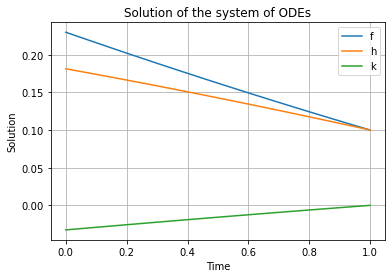

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
(101,) (10, 101)


In [23]:
# Define the system of ODEs
def system_of_odes(t, y):
    dydt = [
        a+2*c*y[0]-(np.power(d,2)*np.power(y[0],2))/A,                 # df/dt = a+2cf-d^2*f^2/A; f(0)=alpa
        b-(B+d*y[1])*d*y[0]/A,                       # dh/dt = b-(B+dh)fd/A; h(0)=beta
        np.power(sigma,2)*y[0]-(B+d*y[1])**2/(4*A)        # dk/dt = sigma^2*f-(B+dh)^2/4A; k(0)=0
    ]
    return dydt

# Initial conditions
initial_conditions = [alpa, beta, 0]  # Initial values for y1, y2, and y3

# Time span
t_span = (0, T)  # Start and end time
t_eval=np.linspace(0, 1, ite+1)
# Solve the system of ODEs
sol = solve_ivp(system_of_odes,t_span, initial_conditions, t_eval=np.linspace(0, 1, ite+1))
#
f=np.flip(sol.y[0])
h=np.flip(sol.y[1])
k=np.flip(sol.y[2])
# Plot the solution
plt.plot(sol.t, f, label='f')
plt.plot(sol.t, h, label='h')
plt.plot(sol.t, k, label='k')
plt.xlabel('Time')
plt.ylabel('Solution')
plt.title('Solution of the system of ODEs')

plt.legend()
plt.grid(True)
plt.show()
print(t_eval)
print(f.shape,state_var.shape)


In [24]:
def optimal_soln_numerical(x,f,h):
    u=-(B+d*(2*x*f+h))/(2*A)
    return u

def optimal_soln_closed(x,t):
    q0=1
    q1=2*c
    q2=-d**2/A
    S=q0*q2
    R=q1
    L1=(R+np.sqrt(R**2-4*S))/2
    L2=(R-np.sqrt(R**2-4*S))/2
    
    top = (-q2*alpa*np.cosh(L1*t)+L2*np.sinh(L2*t))
    bottom = ((-q2*alpa/L1)*np.sinh(L1*t)+np.cosh(L2*t))
    
    f = (A/d**2)*top/bottom
    h = ((-q2*alpa*b/L1**2)*np.cosh(L1*t)+b*np.sinh(L2*t)/L2)/bottom - B/d +(beta+B/d+q2*alpa*b/L1**2)/bottom
#     k = sigma**2*np.log(bottom)   
    u = -(B+d*(2*x*f+h))/(2*A)
    
    return u

def value_func(x,f,h,k):
    V=f*np.power(x,2)+h*x+k
    return V

def total_cost(x,u,ite):
    cost_run=0.0
    for i in range(ite+1):
        if(i<ite):
            cost_run=cost_run+a*np.power(x[i],2)+b*x[i]+A*np.power(u[i],2)+B*u[i]
        else:
            cost_ter=alpa*np.power(x[i],2)+beta*x[i]
    return cost_run*delta.numpy()+cost_ter 

# Neural Network Prediction

In [25]:
# u=optimal_soln(state_var[:, :-1],f,h)
# V=value_func(state_var[:, :-1],f,h,k)
u=np.zeros([M1,ite+1])
u1=np.zeros([M1,ite+1])
V=np.zeros([M1,ite+1])
pred=pred_soln.numpy()
pred_cost=np.zeros(M1)
numeric_cost=np.zeros(M1)
error_percnt=np.zeros(M1)
# print(state_var[0,:].shape,u[0,:].shape,ite)
for i in range(M1):
    #print('state variable',state_var[i].shape,u[i,:].shape,optimal_soln(state_var[i],f,h).shape,pred[i,:].shape)
#     u[i,:]=optimal_soln_closed(state_var[i,:],t_eval)
#     print('\n True solution continuous',u[i,:])
    u1[i,:]=optimal_soln_numerical(state_var[i,:],f,h)
    print('\n Numerical solution',u1[i,:])
    numeric_cost[i]=total_cost(state_var[i,:],u1[i,:],ite)
    print('\n Numerical cost=',numeric_cost[i])
    print('\n Predicted solution',pred[i])
    pred_cost[i]=total_cost(state_var[i,:],pred[i],ite)
    print('\n Predicted cost=',pred_cost[i])
    error_percnt[i]= np.abs(100*(np.abs(numeric_cost[i])-np.abs(pred_cost[i]))/numeric_cost[i])
    print('Percent Error wrt Numeric Cost=',error_percnt[i],'%\n')
    V[i,:]=value_func(state_var[i,:],f,h,k)
    


 Numerical solution [-0.61362501 -0.61300472 -0.61238107 -0.61175827 -0.61113695 -0.61051515
 -0.60989642 -0.60927507 -0.60865632 -0.60804188 -0.60742502 -0.60680775
 -0.6061993  -0.60558286 -0.60497085 -0.6043557  -0.60374546 -0.60313619
 -0.60252637 -0.60191507 -0.60130501 -0.60069578 -0.60008791 -0.59947899
 -0.59887042 -0.59826463 -0.59765647 -0.59705344 -0.59644959 -0.59584659
 -0.59524338 -0.59464542 -0.59404411 -0.59344505 -0.59284536 -0.59224614
 -0.59164544 -0.59105099 -0.59045579 -0.58986395 -0.58926985 -0.58867637
 -0.58808322 -0.58749116 -0.58689994 -0.58630589 -0.58571451 -0.58512532
 -0.58453758 -0.58394932 -0.58336219 -0.58277749 -0.5821952  -0.58161052
 -0.58102793 -0.58044456 -0.57986044 -0.57927903 -0.57869866 -0.5781194
 -0.57754046 -0.57696358 -0.57638098 -0.57580194 -0.57522744 -0.57464929
 -0.57407464 -0.57349975 -0.57292387 -0.57234962 -0.57177558 -0.57120202
 -0.57063032 -0.57005723 -0.56948585 -0.56891502 -0.56834636 -0.56777779
 -0.56720818 -0.56664268 -0.566

In [26]:
# data = np.column_stack((state_var[:,0],pred_cost, numeric_cost,error_percnt))
# np.savetxt('LQC_N100_Cost.txt', data, header=' X0 (Initial Value)         Predicted Cost          Numerical cost          Percent Error', comments='')

# Optimal Solution at different time steps

In [27]:
# import matplotlib.pyplot as plt
# # Create subplots
# fig, axs = plt.subplots(ite-5, 1, figsize=(9, 10))
# ig, axs = plt.subplots(ite-5, 1)
# state_var=state_var[:, :-1]
# for i, ax in enumerate(axs):
#     ax.scatter(state_var[:,i],pred[:,i],color='r',label='X vs Pred', marker='o')
#     ax.scatter(state_var[:,i],u[:,i], color='blue', label='X vs True', marker='*')
#     ax.set_xlabel('State Variable X')
#     ax.set_ylabel('Optimal Soln')
#     ax.set_title(f'Optimal Solution at Time Step {i}')
#     ax.legend()
# # Adjust layout
# plt.tight_layout()
# plt.show()

# Optimal solution for different sample path

In [28]:
# matplotlib.use('Qt5Agg')
# #fig, axs = plt.subplots(M1,1, figsize=(6, 25))
# fig, axs = plt.subplots(10,1)

# # Plot x vs y and x vs z on each subplot
# for i, ax in enumerate(axs):
#     ax.plot(t_eval,pred[i], color='b', label='Predicted')
#     ax.plot(t_eval,u[i], color='r', label='Closed Form')
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Optimal Solution')
#     ax.set_title(f'Optimal solution for the sample path of X_0 = {state_var[i,0]:.2f}')
#     ax.legend()

# # Adjust layout
# plt.tight_layout()

# # Show plot
# plt.show()

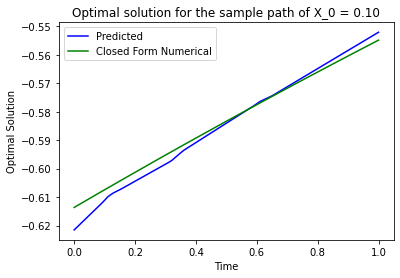

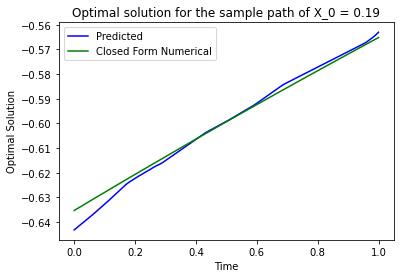

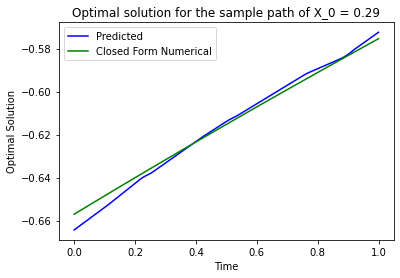

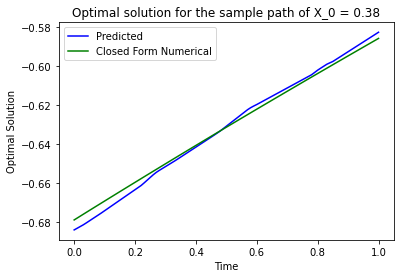

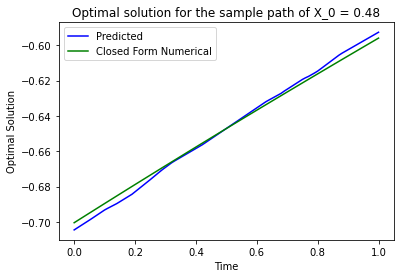

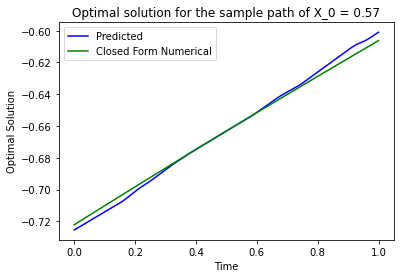

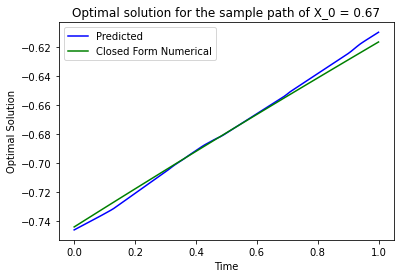

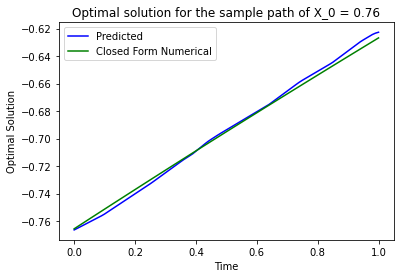

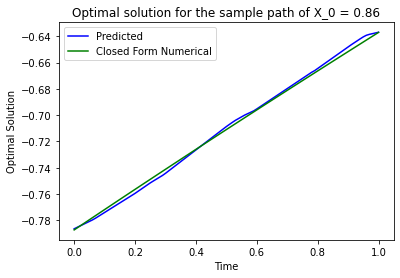

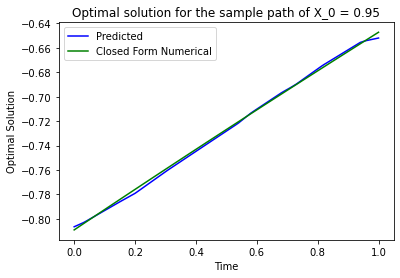

In [29]:
# Loop to create separate figures for each plot
for i in range(M1):  # Assuming you want two separate plots
    plt.figure()  # Create a new figure for each plot
    plt.plot(t_eval, pred[i], color='b', label='Predicted')
#     plt.plot(t_eval, u[i,:], color='r', label='Closed Form continuous')
    plt.plot(t_eval, u1[i,:], color='g', label='Closed Form Numerical')
    
    plt.xlabel('Time')
    plt.ylabel('Optimal Solution')
    plt.title(f'Optimal solution for the sample path of X_0 = {state_var[i,0]:.2f}')
    plt.legend()
    
    # Show each plot separately
    plt.show()


# Saving model and data

In [ ]:
# torch.save(model, 'model_N100_LQC_uniform_0_1_alpa0.1.pth')

# state_var_train=np.squeeze(np.array(state_var_train))

# state_var_dic = {'state variable':state_var_train}

# np.savez('state_var_dic_N100_uniform_0_1_alpa0.1.npz',**state_var_dic)

# cost_numpy_list = [tensor.detach().item() for tensor in cost_ar]
# #state_var_train_list=[tensor.detach().tolist() for tensor in state_var_train]

# my_dic = {'Num_sample':M,'Time_step':ite,'T':T,'a':a,'b':b,'c':c,'d':d,'A':A,'B':B,
#           'alpa':alpa,'beta':beta,'Num_Neoron':neuron_model_psi,'Training_time':total_time,'epoch':max_epoch,
#            'accuracy':10,'Training loss':cost_numpy_list}

# file_path=  'N100_lqc_dic_uniform_0_1_alpa0.1.json'
# with open(file_path,'w') as file:
#     json.dump(my_dic,file)


In [ ]:
# import json
# cost_numpy_list = [tensor.detach().item() for tensor in cost_ar]
# #state_var_train_list=[tensor.detach().tolist() for tensor in state_var_train]

# my_dic = {'Num_sample':M,'Time_step':ite,'T':T,'a':a,'b':b,'c':c,'d':d,'A':A,'B':B,
#           'alpa':alpa,'beta':beta,'Num_Neoron':neuron_model_psi,'Training_time':total_time,'epoch':max_epoch,
#            'accuracy':10,'Training loss':cost_numpy_list}

# file_path=  'N10_lqc_dic_uniform_0_1.json'
# with open(file_path,'w') as file:
#     json.dump(my_dic,file)

In [ ]:
def optimal_soln(x,f,h):
    u=-(B+d*(2*x*f+h))/(2*A)
    return u

def value_func(x,f,h,k):
    V=f*np.power(x,2)+h*x+k
    return V

def total_cost(x,u):
    cost_run=0.0
    for i in range(ite+1):
        if(i<ite):
            cost_run=cost_run+a*np.power(x[i],2)+b*x[i]+A*np.power(u[i],2)+B*u[i]
        else:
            cost_ter=alpa*np.power(x[i],2)+beta*x[i]
    return cost_run*delta.numpy()+cost_ter 

In [ ]:
print(V[0,:].shape)

# Surface plot for the Value function

In [ ]:

from mpl_toolkits.mplot3d import Axes3D

x_grid, y_grid = np.meshgrid(state_var[9,:], t_eval)     # create a grid of x and y values
#z= optimal_soln(state_var[0,:],f,h)  # z values, here we just take sin(r), r = sqrt(x^2 + y^2)
Z =np.tile(V[9,:],(11, 1))

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(x_grid, y_grid, Z, cmap='viridis')  # 'viridis' is just a colormap, you can change it

# Add a color bar which maps values to colors
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('T Label')
ax.set_zlabel('V Label')
ax.set_title('3D Surface Plot for value function')

# Show plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (using state_var and V)
x_grid, y_grid = np.meshgrid(state_var[9, :], t_eval)  # create a grid of x and y values
Z = np.tile(V[9, :], (11, 1))  # Z values, expanded to match the grid

# Create a figure
fig, ax = plt.subplots()

# Plot the contour
contour = ax.contour(x_grid, y_grid, Z, cmap='viridis')  # Create the contour plot

# Optionally, fill the contours
contour_filled = ax.contourf(x_grid, y_grid, Z, cmap='viridis')

# Add a color bar
fig.colorbar(contour_filled)

# Set labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('T Label')
ax.set_title('Contour Plot for Value Function')

# Show plot
plt.show()


In [ ]:
# data = np.load('state_var_dic_N10.npz')

# # Accessing the arrays
# array1 = data['state variable']
# data.close()
# print(array1)

In [ ]:
# import json
# cost_numpy_list = [tensor.detach().item() for tensor in cost_ar]
# #state_var_train_list=[tensor.detach().tolist() for tensor in state_var_train]

# my_dic = {'Num_sample':M,'Time_step':ite,'T':T,'a':a,'b':b,'c':c,'d':d,'A':A,'B':B,
#           'alpa':alpa,'beta':beta,'Num_Neoron':neuron_model_psi,'Training_time':total_time,'epoch':max_epoch,
#            'accuracy':10,'Training loss':cost_numpy_list}

# file_path=  'N10_lqc_dic.json'
# with open(file_path,'w') as file:
#     json.dump(my_dic,file)
